In [1]:
import os
# cd H:\tecky-academy\c17-bad-project-01-tw\data_src
os.chdir(r"D:\tecky-academy\c17-bad-project-01-tw\data_src")

In [2]:
from typing import Reversible
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
# read review
df = pd.read_csv('meta_Movies_and_TV.csv')
df.head()

C:\Users\lau\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"['Movies & TV', 'Movies']",NaN,[],NaN,Understanding Seizures and Epilepsy,[],NaN,NaN,[],"886,503 in Movies & TV (",[],Movies & TV,NaN,NaN,NaN,0000695009,[],[],NaN
1,"['Movies & TV', 'Movies']",NaN,[],NaN,Spirit Led&mdash;Moving By Grace In The Holy S...,[],NaN,NaN,[],"342,688 in Movies & TV (",[],Movies & TV,NaN,NaN,NaN,0000791156,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
2,"['Movies & TV', 'Movies']",NaN,['Disc 1: Flour Power (Scones; Shortcakes; Sou...,NaN,My Fair Pastry (Good Eats Vol. 9),[],NaN,Alton Brown,[],"370,026 in Movies & TV (",[],Movies & TV,NaN,NaN,NaN,0000143529,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
3,"['Movies & TV', 'Movies']",NaN,['Barefoot Contessa Volume 2: On these three d...,NaN,"Barefoot Contessa (with Ina Garten), Entertain...","['B002I5GNW4', 'B005WXPVMM', 'B009UY3W8O', 'B0...",NaN,Ina Garten,[],"342,914 in Movies & TV (","['B002I5GNW4', '0804187045', 'B009UY3W8O', '06...",Movies & TV,NaN,NaN,$74.95,0000143588,[],[],NaN
4,"['Movies & TV', 'Movies']",NaN,['Rise and Swine (Good Eats Vol. 7) includes b...,NaN,Rise and Swine (Good Eats Vol. 7),"['B000P1CKES', 'B000NR4CRM']",NaN,Alton Brown,[],"351,684 in Movies & TV (",['B0015SVNXY'],Movies & TV,NaN,NaN,NaN,0000143502,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN


In [ ]:
# read meta
df_movies = pd.read_csv('Movies_and_TV.csv')
df_movies.head()

In [ ]:
df_join = pd.merge(df_movies, df, how='inner', on='asin')
df_join.head()

In [20]:
n_dims = 10

In [21]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    parameters = {}
    
    uniq_users = np.unique(df['reviewerID'])
    uniq_movies = np.unique(df['asin'])
    
    # mapping raw reviewerID and asin to new id in rating matrix
    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.reviewerID]
        j = movie_to_column[row.asin]
        R[i, j] = row.overall

    return R, train_set, test_set, n_users, n_movies, user_to_row, movie_to_column

R, train_set, test_set, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
print(R)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
np.sum(R)

280882.0

In [23]:
parameters = {}

In [24]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [25]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

In [26]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.trace(np.dot(U, U.T)) + lambda_V * np.trace(np.dot(V, V.T)))

def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['overall'])
        predictions.append(predict(row.loc['reviewerID'], row.loc['asin']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

In [27]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -5156.444651820744


KeyboardInterrupt: 

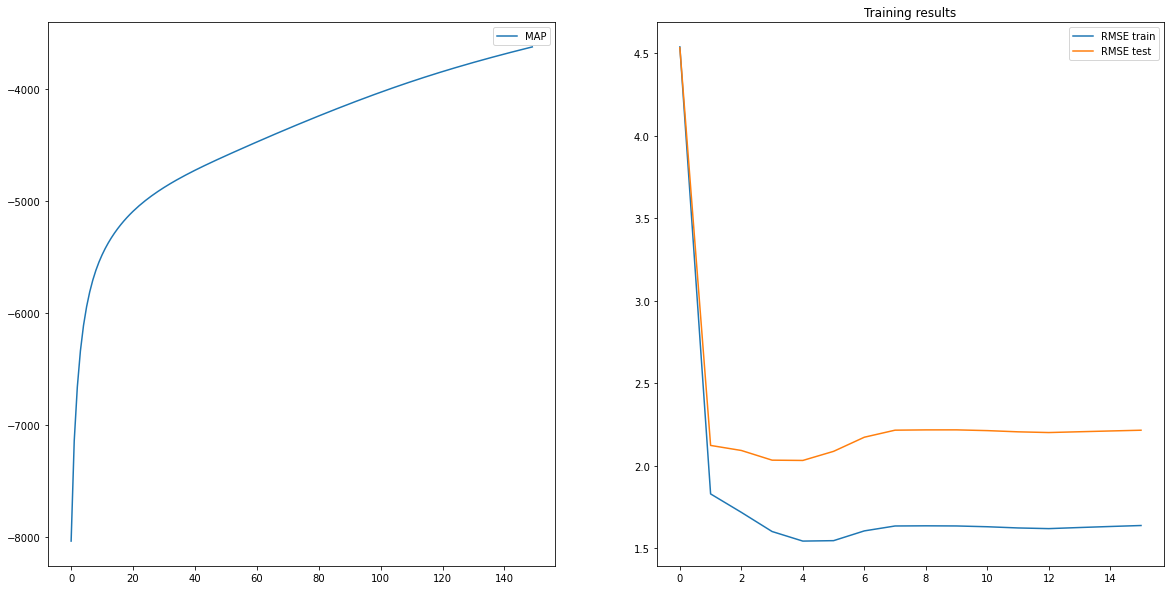

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [15]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.6366501941455414
RMSE of testing set: 2.2145521043707195


In [36]:
user_id = "A3478QRKQDOPQ2"
df_join[df_join['reviewerID'] == user_id].sort_values(by=['overall'], ascending=False).head(10)
df_join[df_join['reviewerID'] == user_id].sort_values(by=['overall']).head(10)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,feature,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
54331,4.0,True,"03 4, 2014",A3478QRKQDOPQ2,0783225911,{'Format:': ' VHS Tape'},jacki,i think she tried to convert him and forgot if...,good evangelism story,1393891200,...,[],"430,594 in Movies & TV (","['B06XGX1FKS', 'B0045HCJSK', 'B072ZMMWZQ', 'B0...",Movies & TV,NaN,NaN,NaN,[],[],NaN
0,5.0,True,"03 11, 2013",A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},jacki,really happy they got evangelised .. spoiler a...,great,1362960000,...,[],"866,012 in Movies & TV (",[],Movies & TV,NaN,NaN,NaN,[],[],NaN


In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [97]:
# look up most likely preferences
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['reviewerID','asin','title','prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = movie_to_column_items[np.where(movie_to_column_items[:, 1] == str(indices[j][0]))][0][0]
    df_row = pd.DataFrame({
        'reviewerID': user_id,
        'asin': movie_id,
        'title': df_join[df_join['asin'] == movie_id].iloc[0]['title'],
        'prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,reviewerID,asin,title,prediction
0,A3478QRKQDOPQ2,078887148X,Enchanted,3.655606
1,A3478QRKQDOPQ2,0767808673,Spice World,3.511531
2,A3478QRKQDOPQ2,0780623614,Dracula:Dead and Loving It VHS,3.359560
3,A3478QRKQDOPQ2,0788821075,Pretty Woman VHS,3.333814
4,A3478QRKQDOPQ2,0005119367,Joseph VHS,3.321775
5,A3478QRKQDOPQ2,078322995X,The Prince of Egypt VHS,3.293207
6,A3478QRKQDOPQ2,0767835069,The Prince of Tides VHS,3.224588
7,A3478QRKQDOPQ2,0001527665,Peace Child VHS,3.135398
8,A3478QRKQDOPQ2,0767805534,Easy Rider VHS,3.083622
9,A3478QRKQDOPQ2,0780662504,Scooby-Doo!: Camp Scare (Blu-ray + DVD + Digit...,3.078039


In [98]:
# look up least likely preferences
df_result = pd.DataFrame(columns=['reviewerID','asin','title','prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = movie_to_column_items[np.where(movie_to_column_items[:, 1] == str(indices[j][0]))][0][0]
    df_row = pd.DataFrame({
        'reviewerID': user_id,
        'asin': movie_id,
        'title': df_join[df_join['asin'] == movie_id].iloc[0]['title'],
        'prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,reviewerID,asin,title,prediction
0,A3478QRKQDOPQ2,0783245130,Creature From the Black Lagoon VHS,1.046248
1,A3478QRKQDOPQ2,0783227361,Dazed and Confused,1.196699
2,A3478QRKQDOPQ2,0783225857,To Kill a Mockingbird,1.393866
3,A3478QRKQDOPQ2,0767834739,Resident Evil: Apocalypse,1.426832
4,A3478QRKQDOPQ2,0783217048,To Wong Foo Thanks for Everything VHS,1.427590
5,A3478QRKQDOPQ2,0788812467,Old Yeller VHS,1.510388
6,A3478QRKQDOPQ2,0767001311,The Very Best of the Bob Newhart Show 6 VHS,1.513125
7,A3478QRKQDOPQ2,0783116926,The Changeling,1.565618
8,A3478QRKQDOPQ2,0783226799,The Jerk,1.654274
9,A3478QRKQDOPQ2,0780620496,For Roseanna VHS,1.716113
